In [ ]:

#  IMPORTS & SETUP

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Reuse  existing helper
import model_helper 
from model_helper import get_df

In [2]:
# GPU Check
print(f"TensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Training on GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print(" GPU not found. Training will be slower on CPU.")

TensorFlow Version: 2.10.1
Training on GPU: /physical_device:GPU:0


In [ ]:
# 2. LOAD DATA (Reusing your Logic)
# Adjust this path to your actual data location
data_path = r'D:\Documents\Projects Kaggle\Smartphone-Sensor-Activity-Recognition\A_DeviceMotion_data'
df = get_df(data_path)

print(f"Total Rows: {len(df)}")
features = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z', 
            'rotationRate.x', 'rotationRate.y', 'rotationRate.z']

Total Rows: 1412865


In [ ]:
# 3. PREPROCESSING (Windows & Encoding)
# A. Create Sliding Windows
# Window Size 100 = 2 seconds @ 50Hz
def create_windows(X_data, y_data, time_steps=100, step=50):
    Xs, ys = [], []
    for i in range(0, len(X_data) - time_steps, step):
        v = X_data.iloc[i:(i + time_steps)].values
        labels = y_data.iloc[i:(i + time_steps)]
        Xs.append(v)
        ys.append(labels.mode()[0])
    return np.array(Xs), np.array(ys)

# B. Encode Labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['activity'])
class_names = list(le.classes_)
print(f"Classes: {class_names}")

# C. Generate Windows
X_windows, y_windows = create_windows(df[features], df['label_encoded'], time_steps=100, step=50)

# CRITICAL CHANGE FOR TENSORFLOW:
# PyTorch wanted: (Batch, Sensors, Time) -> (N, 6, 100)
# TensorFlow/Mobile wants: (Batch, Time, Sensors) -> (N, 100, 6)
# Your create_windows function naturally produces (N, 100, 6), so we DO NOT transpose.
print(f"Input Shape: {X_windows.shape}") # Should be (N, 100, 6)

# D. Split Data
X_train, X_test, y_train, y_test = train_test_split(X_windows, y_windows, test_size=0.2, random_state=42)

Classes: ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
Input Shape: (28256, 100, 6)


In [ ]:
# 4. BUILD MODEL (Native Keras 1D-CNN)
num_classes = len(class_names)

model = keras.Sequential([
    # Input Layer: Accepts [100 steps, 6 sensors]
    layers.Input(shape=(100, 6)),
    
    # Conv Layer 1
    layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    
    # Conv Layer 2
    layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    
    # Flatten & Dense
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    
    # Output Layer
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # 'sparse' handles integer labels (0, 1, 2) automatically
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 98, 32)            608       
                                                                 
 batch_normalization (BatchN  (None, 98, 32)           128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 64)            6208      
                                                                 
 batch_normalization_1 (Batc  (None, 47, 64)           256       
 hNormalization)                                                 
                                                        

In [ ]:
# 5. TRAINING LOOP
print("\nStarting Training...")
history = model.fit(
    X_train, y_train,
    epochs=20,             # Adjustable
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)


Starting Training...
Epoch 1/20
354/354 [==============================] - 50s 45ms/step - loss: 0.6552 - accuracy: 0.7434 - val_loss: 0.4844 - val_accuracy: 0.7247
Epoch 2/20
354/354 [==============================] - 9s 27ms/step - loss: 0.3500 - accuracy: 0.8635 - val_loss: 0.2253 - val_accuracy: 0.9266
Epoch 3/20
354/354 [==============================] - 9s 26ms/step - loss: 0.2806 - accuracy: 0.8952 - val_loss: 0.2256 - val_accuracy: 0.9400
Epoch 4/20
354/354 [==============================] - 9s 26ms/step - loss: 0.2373 - accuracy: 0.9099 - val_loss: 0.1961 - val_accuracy: 0.9328
Epoch 5/20
354/354 [==============================] - 9s 26ms/step - loss: 0.2091 - accuracy: 0.9207 - val_loss: 0.2691 - val_accuracy: 0.9036
Epoch 6/20
354/354 [==============================] - 7s 19ms/step - loss: 0.1998 - accuracy: 0.9223 - val_loss: 0.3581 - val_accuracy: 0.8781
Epoch 7/20
354/354 [==============================] - 8s 22ms/step - loss: 0.1872 - accuracy: 0.9278 - val_loss: 0.1637

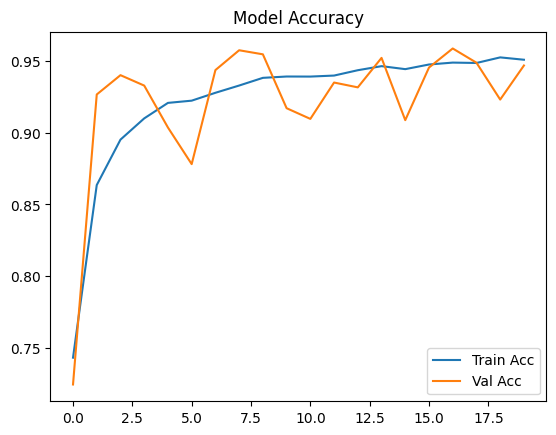

In [7]:
# Plot Results
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()
plt.show()

In [ ]:
# 6. EXPORT TO TFLITE 
print("\nExporting to TFLite...")

# 1. Convert
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# 2. Optimize (Quantization)
# This reduces size by 4x (e.g., 200KB -> 50KB) and speeds up mobile inference
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# 3. Save
model_name = 'activity_model.tflite'
with open(model_name, 'wb') as f:
    f.write(tflite_model)

print(f" SUCCESS! Model saved as '{model_name}'")
print(f" Model Input Shape: [1, 100, 6]")
print(f" Use 'tflite_flutter' to load this file.")


Exporting to TFLite...


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmphz86m61v\assets


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmphz86m61v\assets


 SUCCESS! Model saved as 'activity_model.tflite'
 Model Input Shape: [1, 100, 6]
 Use 'tflite_flutter' to load this file.
